In [1]:
from google.colab import drive
drive.mount('/drive')
import pandas as pd
import numpy as np

from collections import Counter
from collections import OrderedDict

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

Mounted at /drive


In [2]:
import nltk #библиотека для анализа текста
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df_origin = pd.read_csv('/drive/MyDrive/!SberDataScience/Курсовой проект/!main/dataset/final_after_fill_na_salary_median.csv')

In [4]:
origin_columns = df_origin.columns.to_list()
origin_columns

['Employer',
 'Name',
 'Salary',
 'From',
 'To',
 'Experience',
 'Schedule',
 'Skills',
 'Description',
 'Category',
 'Position_level',
 'Salary_median']

In [5]:
cat_columns = ['Experience', 'Schedule', 'Category', 'Position_level']
text_columns = [ 'Skills', 'Description']

In [6]:
df = df_origin[cat_columns+text_columns + ['Salary_median']].copy()

In [7]:
df.head(1)

,Experience,Schedule,Category,Position_level,Skills,Description,Salary_median
0,От 3 до 6 лет,Полный день,Python Develop,Middle,"Git,Redis,Django Framework,Базы данных,Python,...",Компания Qlever Solutions занимается разработк...,170000.0


In [8]:
df.shape

(4010, 7)

In [9]:
df.Experience.value_counts()

От 1 года до 3 лет    2175
От 3 до 6 лет         1522
Нет опыта              242
Более 6 лет             71
Name: Experience, dtype: int64

In [10]:
df['Experience'] = df['Experience'].map({'Нет опыта': 1, 'От 1 года до 3 лет': 2, 'От 3 до 6 лет': 3, 'Более 6 лет': 4})

In [11]:
df.Schedule.value_counts()

Полный день         2733
Удаленная работа    1001
Гибкий график        274
Сменный график         2
Name: Schedule, dtype: int64

In [12]:
df['Schedule'] = df['Schedule'].map({'Сменный график': 1, 'Гибкий график': 2, 'Удаленная работа': 3, 'Полный день': 3})

In [13]:
df.Position_level.value_counts()

Middle    2113
other      981
Senior     370
Junior     306
Lead       240
Name: Position_level, dtype: int64

In [14]:
df['Position_level'] = df['Position_level'].map({'Junior': 1, 'other': 2, 'Middle': 2, 'Senior': 3, 'Lead': 3})

In [15]:
cat_columns += pd.get_dummies(df['Category']).columns.to_list()
cat_columns.remove('Category')

In [16]:
cat_columns

['Experience',
 'Schedule',
 'Position_level',
 'Data Analysis',
 'Data Engineer',
 'Data Science',
 'Python Develop']

In [17]:
df_for_regr = pd.concat([df, pd.get_dummies(df['Category'])], axis = 1)
df_for_regr.drop(columns = ['Category'], inplace = True)
df_for_regr.shape

(4010, 10)

In [18]:
df_for_regr.head(1)

,Experience,Schedule,Position_level,Skills,Description,Salary_median,Data Analysis,Data Engineer,Data Science,Python Develop
0,3,3,2,"Git,Redis,Django Framework,Базы данных,Python,...",Компания Qlever Solutions занимается разработк...,170000.0,0,0,0,1


In [19]:
X_train_regr, X_val_regr, y_train_regr, y_val_regr = train_test_split(df_for_regr[text_columns+cat_columns], df_for_regr['Salary_median'], test_size=0.3, random_state = 33)

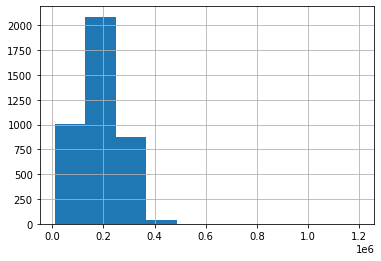

In [20]:
 df_for_regr['Salary_median'].hist()

In [21]:
russian_stop_words = stopwords.words('russian')
snowball = SnowballStemmer(language='russian')


def tokenize_sentence(sentence):
  tokens = word_tokenize(sentence, language = 'russian')
  tokens = sentence.split(' ')
  tokens = [i for i in tokens if i not in [string.punctuation, '...',"'",':',';',',','.','-','+']]
  tokens = [i for i in tokens if i not in russian_stop_words]
  tokens = [snowball.stem(i) for i in tokens]

  return tokens



In [22]:
from sklearn.compose import make_column_transformer, ColumnTransformer

# vectorize_columns_regr = ColumnTransformer(transformers = 
#     [
#      ('tokenizer_Skills', TfidfVectorizer(tokenizer = tokenize_sentence, max_features = 100, min_df=5, max_df=0.7, ngram_range=(1, 1)), 'Skills'),
#      ('tokenizer_Description', TfidfVectorizer(tokenizer = tokenize_sentence, max_features = 100, min_df=5, max_df=0.7, ngram_range=(2, 3)), 'Description'),
#     ]
# )

vectorize_columns_regr = ColumnTransformer(transformers = 
    [
     ('tokenizer_Skills', TfidfVectorizer(tokenizer = tokenize_sentence, max_features = 100, min_df=5, max_df=0.7, ngram_range=(1, 1)), 'Skills'),
     ('tokenizer_Description', TfidfVectorizer(tokenizer = tokenize_sentence, max_features = 100, min_df=5, max_df=0.7, ngram_range=(2, 3)), 'Description'),
    ]
)



In [23]:
tokenized_columns_train_regr = pd.DataFrame.sparse.from_spmatrix(vectorize_columns_regr.fit_transform(X_train_regr))
tokenized_columns_train_regr.shape

(2807, 200)

In [24]:
tokenized_columns_val_regr = pd.DataFrame.sparse.from_spmatrix(vectorize_columns_regr.transform(X_val_regr))
tokenized_columns_val_regr.shape

(1203, 200)

In [25]:
X_train_regr.iloc[:,2:].head(1)

,Experience,Schedule,Position_level,Data Analysis,Data Engineer,Data Science,Python Develop
217,2,3,2,0,1,0,0


In [26]:
X_train_new_regr = pd.concat([tokenized_columns_train_regr, X_train_regr.iloc[:,2:].reset_index(drop = True)], axis = 1)
X_train_new_regr.shape 

(2807, 207)

In [27]:
model_regr = LinearRegression()
model_regr.fit(X_train_new_regr, y_train_regr)

# model_regr = LinearRegression()
# model_regr.fit(X_train_regr.iloc[:,2:], y_train_regr)

LinearRegression()

In [28]:
X_val_new_regr = pd.concat([tokenized_columns_val_regr, X_val_regr.iloc[:,2:].reset_index(drop = True)], axis = 1)
X_val_new_regr.shape 


(1203, 207)

In [29]:
y_pred_regr = model_regr.predict(X_val_new_regr)
y_pred_regr

# y_pred_regr = model_regr.predict(X_val_regr.iloc[:,2:])
# y_pred_regr

array([289328., 166912., 156016., ..., 105120., 308656., 197376.])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89c49b02d0>]],
      dtype=object)

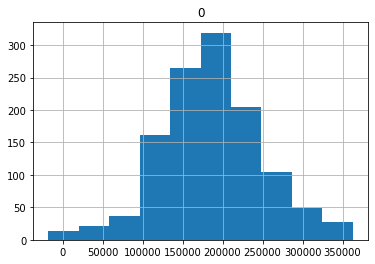

In [30]:
pd.DataFrame(y_pred_regr).hist()

In [31]:
mean_squared_error(y_val_regr, y_pred_regr)

1902010226.2630923

In [32]:
mean_absolute_error(y_val_regr, y_pred_regr) 

28093.197007481296

In [33]:
df_origin = pd.read_csv('/drive/MyDrive/!SberDataScience/Курсовой проект/!main/dataset/final_without_fill_na_salary.csv')

In [34]:
df_origin.shape

(965, 12)

In [35]:
df_origin = df_origin.loc[df_origin['Salary_median'] > 40000]

In [36]:
df_origin.shape

(954, 12)

In [37]:
origin_columns = df_origin.columns.to_list()
origin_columns

['Employer',
 'Name',
 'Salary',
 'From',
 'To',
 'Experience',
 'Schedule',
 'Skills',
 'Description',
 'Category',
 'Position_level',
 'Salary_median']

In [38]:
cat_columns = ['Experience', 'Schedule', 'Category', 'Position_level']
text_columns = [ 'Skills', 'Description']

In [39]:
df = df_origin[cat_columns+text_columns + ['Salary_median']].copy()

In [40]:
df.head(1)

,Experience,Schedule,Category,Position_level,Skills,Description,Salary_median
0,От 3 до 6 лет,Полный день,Python Develop,Middle,"Git,Redis,Django Framework,Базы данных,Python,...",Компания Qlever Solutions занимается разработк...,170000.0


In [41]:
df.shape

(954, 7)

In [42]:
df.Experience.value_counts()

От 1 года до 3 лет    471
От 3 до 6 лет         400
Нет опыта              61
Более 6 лет            22
Name: Experience, dtype: int64

In [43]:
df['Experience'] = df['Experience'].map({'Нет опыта': 1, 'От 1 года до 3 лет': 2, 'От 3 до 6 лет': 3, 'Более 6 лет': 4})

In [44]:
df.Schedule.value_counts()

Полный день         529
Удаленная работа    326
Гибкий график        97
Сменный график        2
Name: Schedule, dtype: int64

In [45]:
df['Schedule'] = df['Schedule'].map({'Сменный график': 1, 'Гибкий график': 2, 'Удаленная работа': 3, 'Полный день': 3})

In [46]:
df.Position_level.value_counts()

Middle    485
other     226
Senior    102
Junior     89
Lead       52
Name: Position_level, dtype: int64

In [47]:
df['Position_level'] = df['Position_level'].map({'Junior': 1, 'other': 2, 'Middle': 2, 'Senior': 3, 'Lead': 3})

In [48]:
cat_columns += pd.get_dummies(df['Category']).columns.to_list()
cat_columns.remove('Category')

In [49]:
cat_columns

['Experience',
 'Schedule',
 'Position_level',
 'Data Analysis',
 'Data Engineer',
 'Data Science',
 'Python Develop']

In [50]:
df_for_regr = pd.concat([df, pd.get_dummies(df['Category'])], axis = 1)
df_for_regr.drop(columns = ['Category'], inplace = True)
df_for_regr.shape

(954, 10)

In [51]:
df_for_regr.head(1)

,Experience,Schedule,Position_level,Skills,Description,Salary_median,Data Analysis,Data Engineer,Data Science,Python Develop
0,3,3,2,"Git,Redis,Django Framework,Базы данных,Python,...",Компания Qlever Solutions занимается разработк...,170000.0,0,0,0,1


In [52]:
X_train_regr, X_val_regr, y_train_regr, y_val_regr = train_test_split(df_for_regr[text_columns+cat_columns], df_for_regr['Salary_median'], test_size=0.3, random_state = 33)

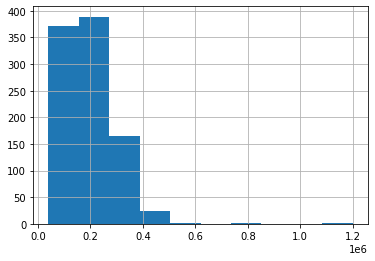

In [53]:
 df_for_regr['Salary_median'].hist()

In [54]:
russian_stop_words = stopwords.words('russian')
snowball = SnowballStemmer(language='russian')


def tokenize_sentence(sentence):
  tokens = word_tokenize(sentence, language = 'russian')
  tokens = sentence.split(' ')
  tokens = [i for i in tokens if i not in [string.punctuation, '...',"'",':',';',',','.','-','+']]
  tokens = [i for i in tokens if i not in russian_stop_words]
  tokens = [snowball.stem(i) for i in tokens]

  return tokens



In [55]:
from sklearn.compose import make_column_transformer, ColumnTransformer

# vectorize_columns_regr = ColumnTransformer(transformers = 
#     [
#      ('tokenizer_Skills', TfidfVectorizer(tokenizer = tokenize_sentence, max_features = 100, min_df=5, max_df=0.7, ngram_range=(1, 1)), 'Skills'),
#      ('tokenizer_Description', TfidfVectorizer(tokenizer = tokenize_sentence, max_features = 100, min_df=5, max_df=0.7, ngram_range=(2, 3)), 'Description'),
#     ]
# )

vectorize_columns_regr = ColumnTransformer(transformers = 
    [
     ('tokenizer_Skills', TfidfVectorizer(tokenizer = tokenize_sentence, max_features = 100, min_df=5, max_df=0.7, ngram_range=(1, 1)), 'Skills'),
     ('tokenizer_Description', TfidfVectorizer(tokenizer = tokenize_sentence, max_features = 100, min_df=5, max_df=0.7, ngram_range=(2, 3)), 'Description'),
    ]
)



In [56]:
tokenized_columns_train_regr = pd.DataFrame.sparse.from_spmatrix(vectorize_columns_regr.fit_transform(X_train_regr))
tokenized_columns_train_regr.shape

(667, 143)

In [57]:
tokenized_columns_val_regr = pd.DataFrame.sparse.from_spmatrix(vectorize_columns_regr.transform(X_val_regr))
tokenized_columns_val_regr.shape

(287, 143)

In [58]:
X_train_regr.iloc[:,2:].head(1)

,Experience,Schedule,Position_level,Data Analysis,Data Engineer,Data Science,Python Develop
570,3,3,3,0,0,0,1


In [59]:
X_train_new_regr = pd.concat([tokenized_columns_train_regr, X_train_regr.iloc[:,2:].reset_index(drop = True)], axis = 1)
X_train_new_regr.shape 

(667, 150)

In [60]:
model_regr = LinearRegression()
model_regr.fit(X_train_new_regr, y_train_regr)

# model_regr = LinearRegression()
# model_regr.fit(X_train_regr.iloc[:,2:], y_train_regr)

LinearRegression()

In [61]:
X_val_new_regr = pd.concat([tokenized_columns_val_regr, X_val_regr.iloc[:,2:].reset_index(drop = True)], axis = 1)
X_val_new_regr.shape 


(287, 150)

In [62]:
y_pred_regr = model_regr.predict(X_val_new_regr)
# y_pred_regr

# y_pred_regr = model_regr.predict(X_val_regr.iloc[:,2:])
# y_pred_regr

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89c498cc50>]],
      dtype=object)

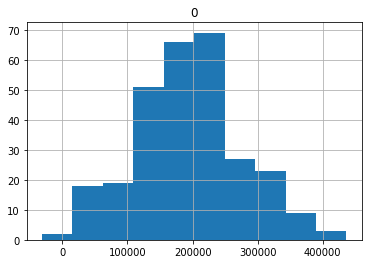

In [63]:
pd.DataFrame(y_pred_regr).hist()

In [64]:
mean_squared_error(y_val_regr, y_pred_regr)

5064241352.138502

In [65]:
mean_absolute_error(y_val_regr, y_pred_regr) 

56496.57665505227

In [66]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 48 kB/s 


In [67]:
import catboost as cb

In [71]:
catboost = cb.CatBoostRegressor( n_estimators=1000,
                                # learning_rate = 0.02898,   
                                depth = 4,
                                l2_leaf_reg = 4,
                                # grow_policy = 'SymmetricTree',
                                loss_function='MAE',
                                random_state=46,
                                # bootstrap_type='Bernoulli',
                                # subsample = 0.62368,
                                )
catboost.fit(X_train_new_regr, y_train_regr,
              verbose = 100
              )
y_pred = catboost.predict(X_val_new_regr)

0:	learn: 76973.3632714	total: 12.6ms	remaining: 12.6s
100:	learn: 55393.1830577	total: 1.24s	remaining: 11s
200:	learn: 49787.6948328	total: 1.97s	remaining: 7.82s
300:	learn: 45657.3968848	total: 2.79s	remaining: 6.48s
400:	learn: 42375.6503228	total: 3.52s	remaining: 5.26s
500:	learn: 39669.5092973	total: 4.42s	remaining: 4.4s
600:	learn: 37734.3806810	total: 5.14s	remaining: 3.41s
700:	learn: 35724.9579442	total: 6s	remaining: 2.56s
800:	learn: 34214.1842751	total: 6.52s	remaining: 1.62s
900:	learn: 32972.8116956	total: 6.91s	remaining: 759ms
999:	learn: 31914.0385537	total: 7.28s	remaining: 0us


In [72]:
mean_absolute_error(y_val_regr, y_pred) 

48498.3766268882